In [6]:
# useful additional packages
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np
import networkx as nx

from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram

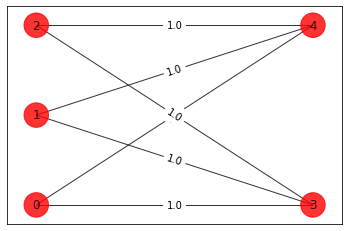

In [10]:
# Generating a graph of 4 nodes

n = 5  # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
elist = [(0,3,1.0),(0,4,1.0),(1,3,1.0),(1,4,1.0),(2,3,1.0),(2,4,1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ["r" for node in G.nodes()]
pos = nx.bipartite_layout(G,[0,1,2])


def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


draw_graph(G, colors, pos)

In [12]:
# Computing the weight matrix from the random graph
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]
print(w)

[[0. 0. 0. 1. 1.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 1. 1.]
 [1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0.]]


case = [0, 0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0, 0] cost = 2.0
case = [0, 1, 0, 0, 0] cost = 2.0
case = [1, 1, 0, 0, 0] cost = 4.0
case = [0, 0, 1, 0, 0] cost = 2.0
case = [1, 0, 1, 0, 0] cost = 4.0
case = [0, 1, 1, 0, 0] cost = 4.0
case = [1, 1, 1, 0, 0] cost = 6.0
case = [0, 0, 0, 1, 0] cost = 3.0
case = [1, 0, 0, 1, 0] cost = 3.0
case = [0, 1, 0, 1, 0] cost = 3.0
case = [1, 1, 0, 1, 0] cost = 3.0
case = [0, 0, 1, 1, 0] cost = 3.0
case = [1, 0, 1, 1, 0] cost = 3.0
case = [0, 1, 1, 1, 0] cost = 3.0
case = [1, 1, 1, 1, 0] cost = 3.0
case = [0, 0, 0, 0, 1] cost = 3.0
case = [1, 0, 0, 0, 1] cost = 3.0
case = [0, 1, 0, 0, 1] cost = 3.0
case = [1, 1, 0, 0, 1] cost = 3.0
case = [0, 0, 1, 0, 1] cost = 3.0
case = [1, 0, 1, 0, 1] cost = 3.0
case = [0, 1, 1, 0, 1] cost = 3.0
case = [1, 1, 1, 0, 1] cost = 3.0
case = [0, 0, 0, 1, 1] cost = 6.0
case = [1, 0, 0, 1, 1] cost = 4.0
case = [0, 1, 0, 1, 1] cost = 4.0
case = [1, 1, 0, 1, 1] cost = 2.0
case = [0, 0, 1, 1, 1] cost = 4.0
case = [1, 0, 

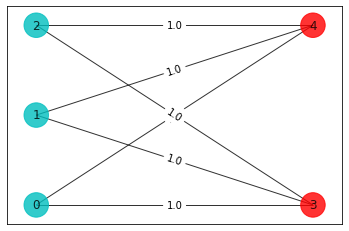

In [13]:
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i, j] * x[i] * (1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print("case = " + str(x) + " cost = " + str(cost))

colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)
print("\nBest solution = " + str(xbest_brute) + " cost = " + str(best_cost_brute))

In [14]:
#Generating Quadratic program and mapping to Ising problem
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Problem name: Max-cut

Maximize
  -2*x_0*x_3 - 2*x_0*x_4 - 2*x_1*x_3 - 2*x_1*x_4 - 2*x_2*x_3 - 2*x_2*x_4 + 2*x_0
  + 2*x_1 + 2*x_2 + 3*x_3 + 3*x_4

Subject to
  No constraints

  Binary variables (5)
    x_0 x_1 x_2 x_3 x_4

Offset: -3.0
Ising Hamiltonian:
0.5 * IZIIZ
+ 0.5 * IZIZI
+ 0.5 * IZZII
+ 0.5 * ZIIIZ
+ 0.5 * ZIIZI
+ 0.5 * ZIZII


In [15]:
# solving Quadratic Program using exact classical eigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result.prettyprint())

objective function value: 6.0
variable values: x_0=0.0, x_1=0.0, x_2=0.0, x_3=1.0, x_4=1.0
status: SUCCESS


energy: -3.0
max-cut objective: -6.0
solution: [0 0 0 1 1]
solution objective: 6.0


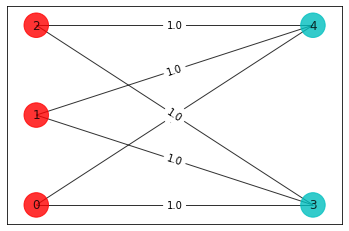

In [16]:
# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

In [17]:
#Running it on a quantum computer
algorithm_globals.random_seed = 123
seed = 10598
backend = Aer.get_backend("aer_simulator_statevector")
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

energy: -2.8799573001508736
time: 2.911086320877075
max-cut objective: -5.879957300150874
solution: [0. 0. 0. 1. 1.]
solution objective: 6.0


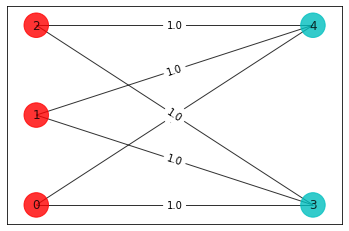

In [18]:
# construct VQE
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = VQE(ry, optimizer=spsa, quantum_instance=quantum_instance)

# run VQE
result = vqe.compute_minimum_eigenvalue(qubitOp)

# print results
x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

# plot results
colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

objective function value: 6.0
variable values: x_0=1.0, x_1=1.0, x_2=1.0, x_3=0.0, x_4=0.0
status: SUCCESS


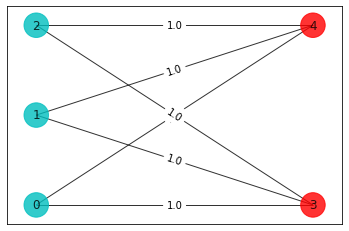

In [19]:
# create minimum eigen optimizer based on VQE
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result.prettyprint())

colors = ["r" if result.x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)